# Part 1 initial notebook

Note that in its initial form the notebook will not run. You will need to amend two cells in order to successfully run the notebook. See `assessment.ipynb` for instructions.

In [1]:
import numpy as np
%matplotlib inline

from examples.seismic import Model, AcquisitionGeometry, Receiver, plot_velocity, plot_image
from examples.seismic.acoustic import AcousticWaveSolver

import matplotlib.pyplot as plt

from devito import Function, TimeFunction, Eq, Operator, norm, mmax, configuration

configuration['log-level'] = 'WARNING'

In [2]:
nshots = 9  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot
fwi_iterations = 50  # Number of outer FWI iterations

In [3]:
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

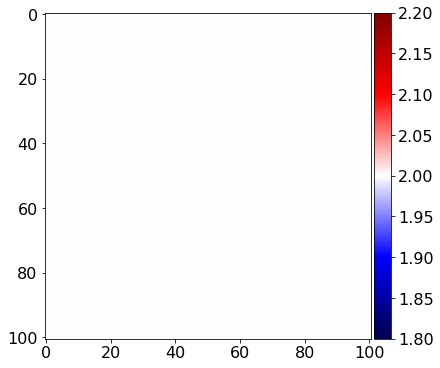

In [4]:
vback = 2.0
v0 = np.full(shape, vback)

plot_image(v0, cmap="seismic")

In [5]:
# Define initial model

model0 = Model(vp=v0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, dt=2.449, bcs="damp")

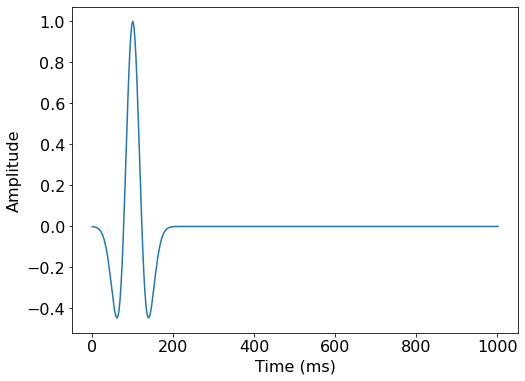

In [6]:
# Define acquisition geometry: source

t0 = 0.
tn = 1000.
f0 = 0.010
# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model0.domain_size) * .5
src_coordinates[0, 0] = 20.  # Depth is 20m

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model0.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Geometry

geometry = AcquisitionGeometry(model0, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

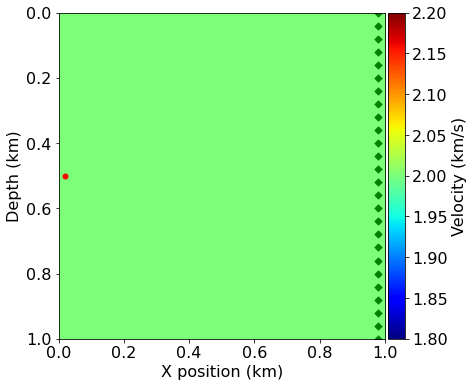

In [7]:
# Plot acquisition geometry with initial guess of the velocity model
plot_velocity(model0, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

In [8]:
# Create solver

solver = AcousticWaveSolver(model0, geometry, space_order=2)

In [9]:
# Prepare the varying source locations sources
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

## For part 1 you will need to edit the cell below

In [10]:
# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
#     residual = None
    residual.data[:] = dsyn.data[:] - dobs[:]
    return residual

## For part 1 you will need to edit the cell below

In [11]:
# Create FWI gradient kernel

def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model0.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model0.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model0.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model0.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Load synthetic data from file
        d_obs = np.load("../data/shot" + str(i) + ".npy", allow_pickle=True)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

# fwi_gradient(model0.vp)

In [12]:
from sympy import Min, Max
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

## In part 1 you do not need to edit the cell below.
## In part 2 you will need to modify the manner in which alpha is determined in the cell below.

In [13]:
import copy
def line_search(model0, phi, direction):
    alpha = .1 / mmax(direction)
    c1 = 1e-4
    c2 = 0.9
    for i in range(fwi_iterations):
        model_tmp = copy.deepcopy(model0)
        update_with_box(model_tmp.vp, alpha, direction)
        phi_new, direction_new = fwi_gradient(model_tmp.vp)
        # check Wolfe Conditions:
        if phi_new <= phi + c1 * alpha * norm(direction) and norm(direction_new) >= c2 * norm(direction):
            break
        alpha /= 2.
    return alpha

In [14]:
# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp)

    # Store the history of the functional values
    history[i] = phi

    # In part 2 you will need to change how this alpha is chosen 
#     alpha = .05 / mmax(direction)
    alpha = line_search(model0, phi, direction)

    # Update the model estimate and enforce minimum/maximum values
    update_with_box(model0.vp , alpha , direction)

    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Objective value is 80077.962289 at iteration 1
Objective value is 65812.904198 at iteration 2
Objective value is 59022.645292 at iteration 3
Objective value is 52838.358590 at iteration 4
Objective value is 47221.729219 at iteration 5
Objective value is 42135.447086 at iteration 6
Objective value is 37543.757095 at iteration 7
Objective value is 33412.102818 at iteration 8
Objective value is 29707.029856 at iteration 9
Objective value is 26396.202849 at iteration 10
Objective value is 23448.354084 at iteration 11
Objective value is 20833.044639 at iteration 12
Objective value is 18520.288758 at iteration 13
Objective value is 16481.103946 at iteration 14
Objective value is 14687.375791 at iteration 15
Objective value is 13112.618515 at iteration 16
Objective value is 11731.076533 at iteration 17
Objective value is 10519.028520 at iteration 18
Objective value is 9454.546711 at iteration 19
Objective value is 8516.154036 at iteration 20
Objective value is 7685.182365 at iteration 21
Obje

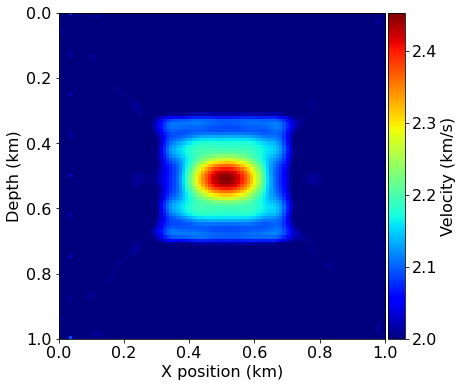

In [15]:
# Plot inverted velocity model
plot_velocity(model0)

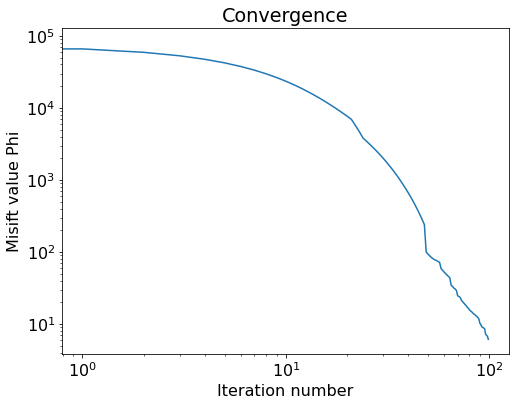

In [16]:
# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

## Part 2(i)

The key point of my line search algorithm is that I will use the current $\alpha$ value to *try to* update the model and then get a *temporary* residual. After that, the algorithm will check whether the Wolfe Conditions are satisfied or not.
<math>
\begin{align}
\textbf{i)} & \quad f(\mathbf{x}_k+\alpha_k\mathbf{p}_k)\leq f(\mathbf{x}_k) + c_1\alpha_k \mathbf{p}_k^{\mathrm T} \nabla f(\mathbf{x}_k),\\[6pt]
\textbf{ii)} & \quad {-\mathbf{p}}_k^{\mathrm T}\nabla f(\mathbf{x}_k+\alpha_k\mathbf{p}_k) \leq -c_2\mathbf{p}_k^{\mathrm T}\nabla f(\mathbf{x}_k),
\end{align}
</math>

In the line search algorithm, we would like the value of $\alpha$ not to be too small since it will decrease the efficiency, however, we would like the value of $\alpha$ not to be too big since it will **overshooting** and then make the algorithm unstable.


Condition i) ensures that the step length ${\alpha_k}$ decreases the residual 'sufficiently', and condition ii) ensures that the slope has been reduced sufficiently. Conditions i) and ii) can be interpreted as respectively providing an upper and lower bound on the admissible step length values. At the same time, we should decrease the value of $\alpha$ since we can avoid the *overshooting*.

## Part 2(ii)

### Space order of solver

We can treat the space order of solver as the the precision of the Taylor series of wave equation. I changed the value of space order for the solver from 4 to 16, and then do iteration for 20 times, from the objective value and the convergence plot, we can see that the precision will improve. However, the cost of the simulation will improve at the same time.

### Number of iteration

We can easily find that when we increase the number of iteration, the residual will decrease and the precision will improve. But we still need to consider the cost of time for more iterations. From the implementation above, we can find that when the number of iteration is between 100~150, we can get a better balance between cost and precision.

### True underlying velocity model

From the plot showed above, we can approximate the image from simulation as the plot of the true underlying velocity model. Also, we can see that the smaller the residual is, the more similar the plot is.